# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import torch
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Let's implement DDPG

In [5]:
import time

def ddpg_continuous(num_agents, n_episodes=5000):
    saves = [False for i in range(10)]

    scores_deque = deque(maxlen=100)
    scores_deque_avg = []
    scores = []
    start_time = time.time()
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        #state = torch.tensor(env.reset(), dtype=torch.int8, device=device)
        for agent in agents:
            agent.reset()#reset the OUNoise
        score = np.zeros(num_agents)
        score_avg = 0
        while True:
            #actions = list()
            #for agent, state in zip(agents, states):
            #    actions.append(agent.act(state))
            actions = [agent.act(states[i]) for i in range(num_agents)]

            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
        
            #for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            agent.step(states, actions, rewards, next_states, dones)
            #for agent, state, action, reward, next_state, done in zip(agents, states, actions, rewards, next_states,
            #                                                          dones):
            #    agent.step(state, action, reward, next_state, done)
                
            states = next_states
            score += np.array(rewards)
            if np.any(dones):
                break
        maxScore = np.max(score)        
        #score_avg = np.mean(score)
        scores.append(maxScore)
        scores_deque.append(maxScore)
        scores_deque_avg.append(np.mean(scores_deque))
        now_time = time.time() - start_time
        
        if i_episode%10 == 0:
            print('\rEpisode {} Average Score deque: {:.2f}  time: {}'.format(i_episode, np.mean(scores_deque),
                                                                                            now_time, end=""))
        for i_save in range(len(saves)):
            if i_episode>100 and np.mean(scores_deque)>(0.5+0.1*i_save) and saves[i_save] == False:
                saves[i_save] = True
            #print("envionment solved")
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth') # save weight for actor
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') # save weight for critic
                print('\rSaved actor and local network for Average Score deque is >= {:.2f}'.format(0.5+0.1*i_save, end=""))
            #torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor_2.pth') # save weight for actor
            #torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic_2.pth') # save weight for critic
            #return scores,scores_deque_avg
        
        if i_episode%200 == 0:
            #torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth') # save weight for actor
            #torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') # save weight for critic
            #window = int(i_episode/5 +1)
            #filter = np.ones(window)/window
            fig = plt.figure(figsize=(20,10))
            ax = fig.add_subplot(111)
            plt.plot(scores,label = 'Real scores')
            #plt.plot(np.convolve(scores, filter)[:-window],label = 'Smoothed scores along time')
            plt.plot(scores_deque_avg,label = 'Mean of the 100 last episodes')
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
            
    return scores,scores_deque_avg



### Here we train the Agent

Episode 10 Average Score deque: 0.01  time: 3.6208434104919434
Episode 20 Average Score deque: 0.01  time: 5.376034498214722
Episode 30 Average Score deque: 0.00  time: 7.1454668045043945
Episode 40 Average Score deque: 0.00  time: 8.855314016342163
Episode 50 Average Score deque: 0.00  time: 10.568733930587769
Episode 60 Average Score deque: 0.00  time: 12.307032346725464
Episode 70 Average Score deque: 0.00  time: 14.304874897003174
Episode 80 Average Score deque: 0.00  time: 16.438891410827637
Episode 90 Average Score deque: 0.00  time: 18.114132165908813
Episode 100 Average Score deque: 0.00  time: 20.113352298736572
Episode 110 Average Score deque: 0.00  time: 21.807462692260742
Episode 120 Average Score deque: 0.00  time: 23.751981496810913
Episode 130 Average Score deque: 0.00  time: 25.730681657791138
Episode 140 Average Score deque: 0.00  time: 27.75225043296814
Episode 150 Average Score deque: 0.00  time: 29.621690273284912
Episode 160 Average Score deque: 0.00  time: 31.5126

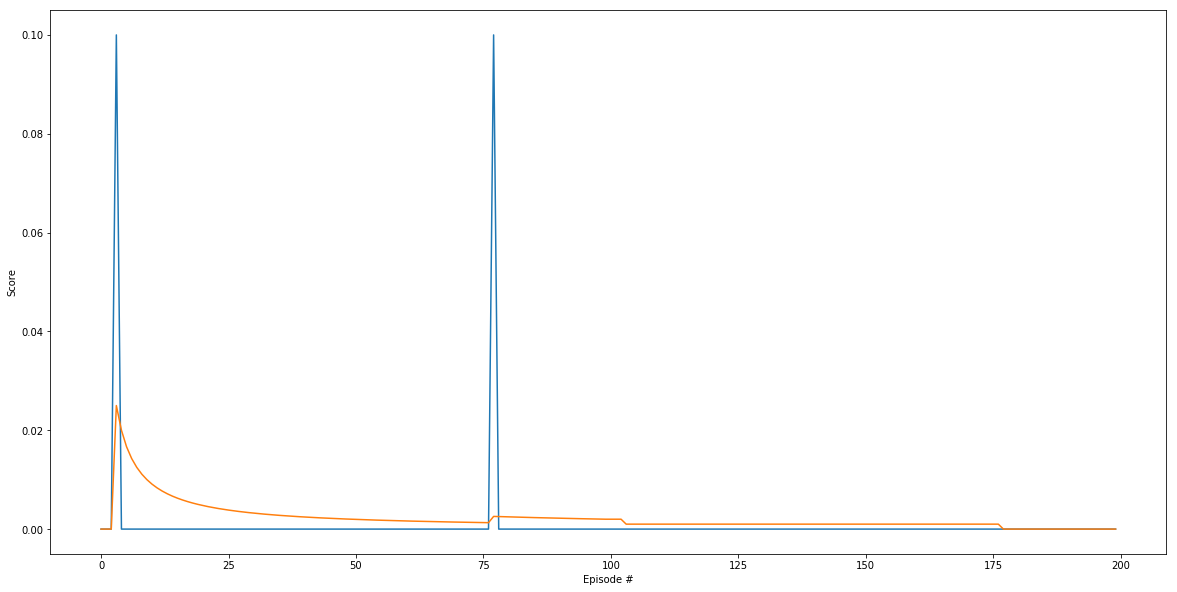

Episode 210 Average Score deque: 0.00  time: 42.57940912246704
Episode 220 Average Score deque: 0.00  time: 44.56809449195862
Episode 230 Average Score deque: 0.00  time: 46.814146757125854
Episode 240 Average Score deque: 0.00  time: 48.8201322555542
Episode 250 Average Score deque: 0.00  time: 51.08656406402588
Episode 260 Average Score deque: 0.00  time: 53.30082988739014
Episode 270 Average Score deque: 0.00  time: 55.37533473968506
Episode 280 Average Score deque: 0.00  time: 57.693300008773804
Episode 290 Average Score deque: 0.00  time: 60.62299561500549
Episode 300 Average Score deque: 0.00  time: 64.12587237358093
Episode 310 Average Score deque: 0.00  time: 66.5925064086914
Episode 320 Average Score deque: 0.00  time: 69.20047640800476
Episode 330 Average Score deque: 0.00  time: 71.75696420669556
Episode 340 Average Score deque: 0.00  time: 74.61227035522461
Episode 350 Average Score deque: 0.01  time: 81.03033542633057
Episode 360 Average Score deque: 0.01  time: 83.8710007

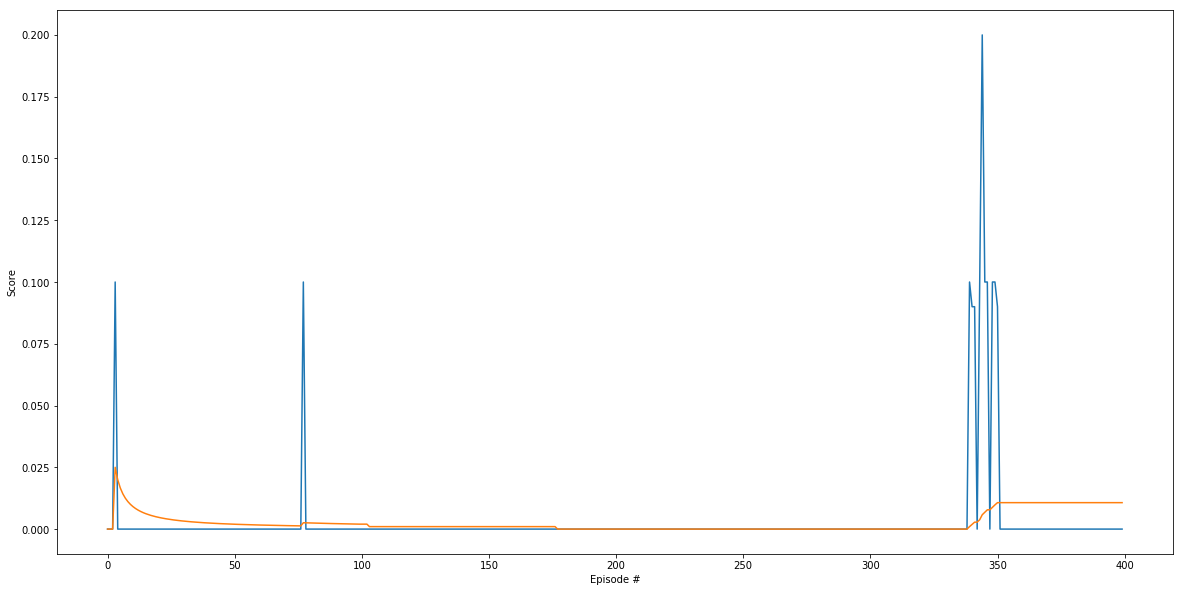

Episode 410 Average Score deque: 0.01  time: 97.42242860794067
Episode 420 Average Score deque: 0.01  time: 99.96864891052246
Episode 430 Average Score deque: 0.01  time: 102.40829205513
Episode 440 Average Score deque: 0.01  time: 104.94925737380981
Episode 450 Average Score deque: 0.00  time: 107.49619388580322
Episode 460 Average Score deque: 0.00  time: 110.13730335235596
Episode 470 Average Score deque: 0.00  time: 112.68452525138855
Episode 480 Average Score deque: 0.00  time: 115.73993182182312
Episode 490 Average Score deque: 0.00  time: 118.29001450538635
Episode 500 Average Score deque: 0.00  time: 120.95901465415955
Episode 510 Average Score deque: 0.00  time: 124.0052981376648
Episode 520 Average Score deque: 0.00  time: 127.3450186252594
Episode 530 Average Score deque: 0.00  time: 130.07648873329163
Episode 540 Average Score deque: 0.00  time: 132.69814038276672
Episode 550 Average Score deque: 0.00  time: 135.44795203208923
Episode 560 Average Score deque: 0.00  time: 13

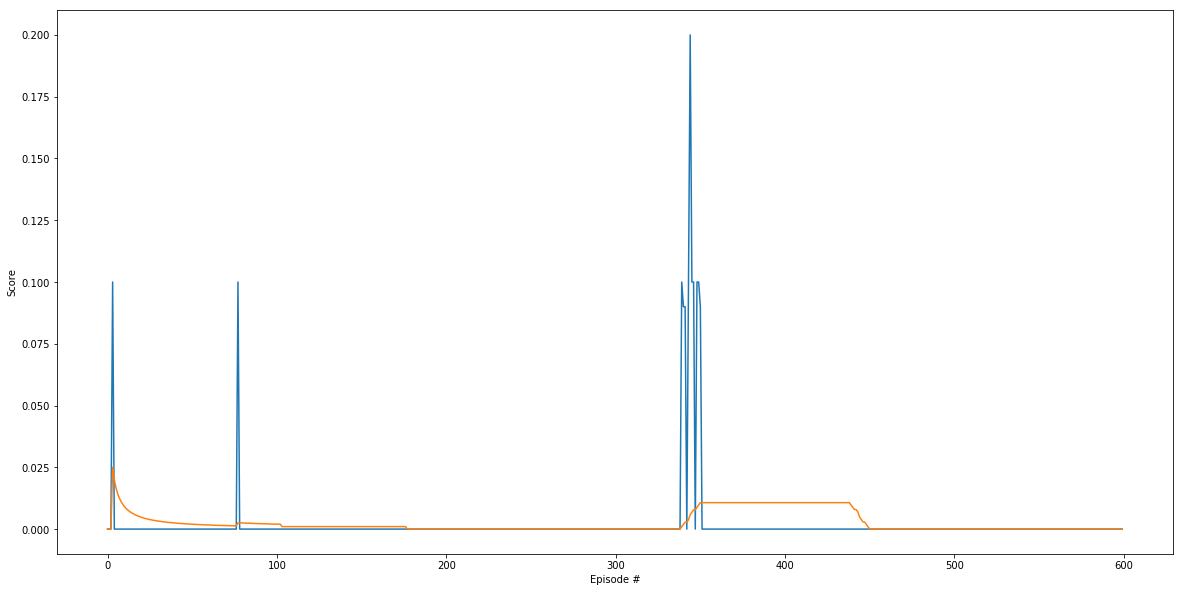

Episode 610 Average Score deque: 0.00  time: 152.0014717578888
Episode 620 Average Score deque: 0.00  time: 154.55946612358093
Episode 630 Average Score deque: 0.00  time: 157.0744161605835
Episode 640 Average Score deque: 0.00  time: 159.68109893798828
Episode 650 Average Score deque: 0.00  time: 162.30562806129456
Episode 660 Average Score deque: 0.00  time: 164.8613018989563
Episode 670 Average Score deque: 0.00  time: 167.19286274909973
Episode 680 Average Score deque: 0.00  time: 169.4218933582306
Episode 690 Average Score deque: 0.00  time: 172.06508421897888
Episode 700 Average Score deque: 0.01  time: 175.55798029899597
Episode 710 Average Score deque: 0.01  time: 178.7451775074005
Episode 720 Average Score deque: 0.02  time: 182.8903386592865
Episode 730 Average Score deque: 0.02  time: 186.17023944854736
Episode 740 Average Score deque: 0.02  time: 189.0066876411438
Episode 750 Average Score deque: 0.02  time: 192.8087887763977
Episode 760 Average Score deque: 0.03  time: 196

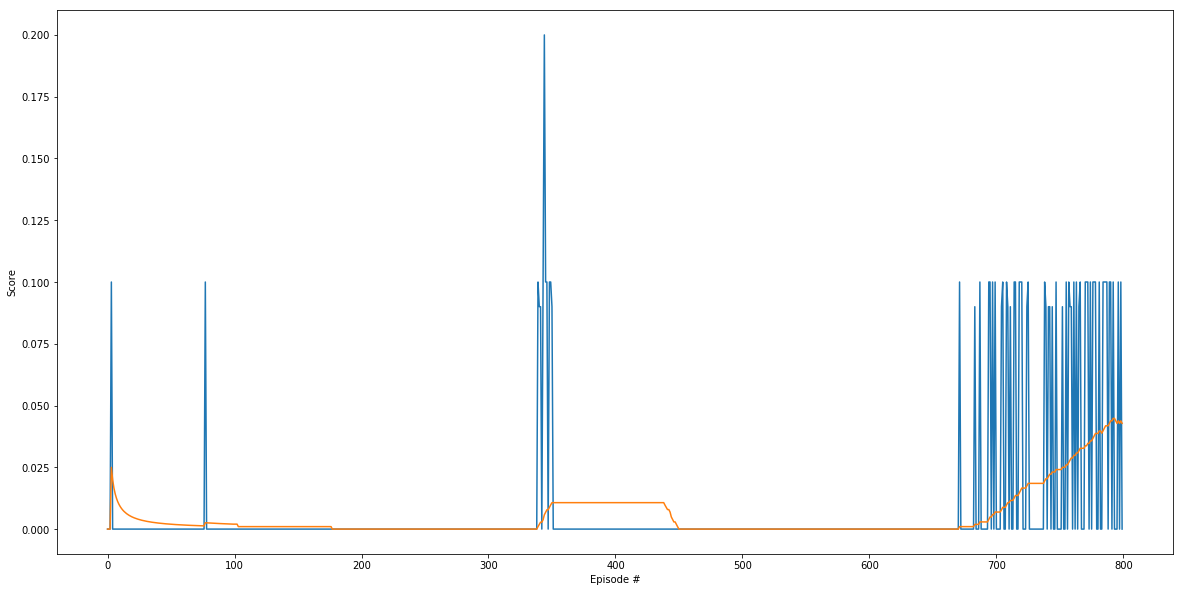

Episode 810 Average Score deque: 0.05  time: 217.4216856956482
Episode 820 Average Score deque: 0.05  time: 223.4721496105194
Episode 830 Average Score deque: 0.05  time: 229.4608018398285
Episode 840 Average Score deque: 0.06  time: 234.51364827156067
Episode 850 Average Score deque: 0.07  time: 240.010972738266
Episode 860 Average Score deque: 0.07  time: 244.98152661323547
Episode 870 Average Score deque: 0.07  time: 249.27877402305603
Episode 880 Average Score deque: 0.07  time: 253.0253040790558
Episode 890 Average Score deque: 0.06  time: 255.90699791908264
Episode 900 Average Score deque: 0.06  time: 258.1853015422821
Episode 910 Average Score deque: 0.06  time: 264.0560166835785
Episode 920 Average Score deque: 0.05  time: 267.17109060287476
Episode 930 Average Score deque: 0.05  time: 270.6239197254181
Episode 940 Average Score deque: 0.05  time: 276.90581917762756
Episode 950 Average Score deque: 0.04  time: 281.1535234451294
Episode 960 Average Score deque: 0.05  time: 286.7

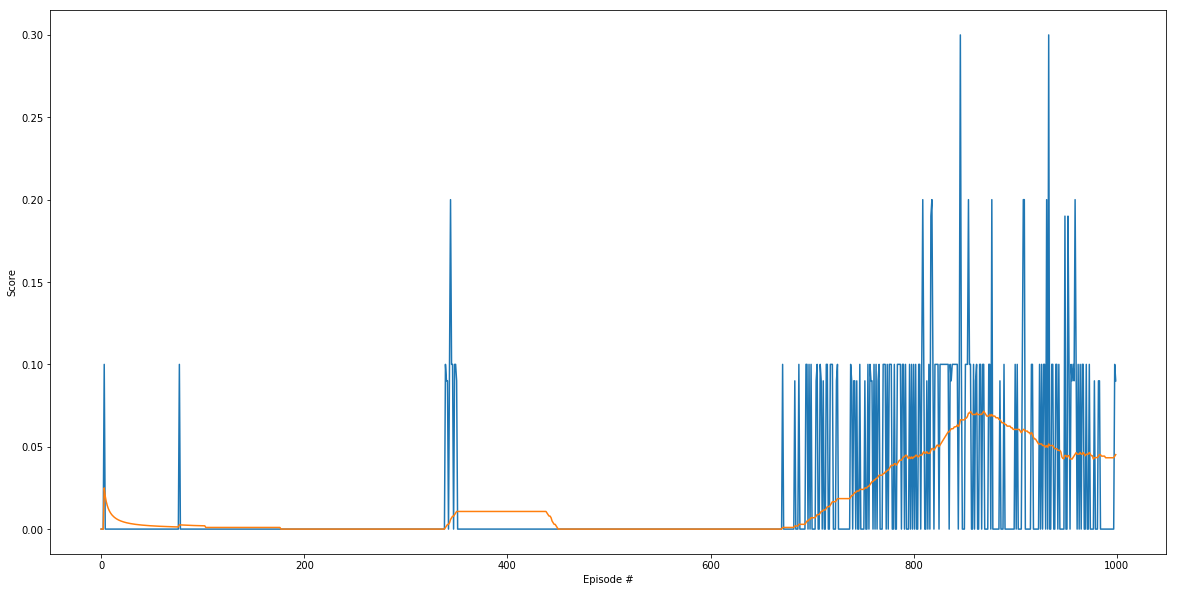

Episode 1010 Average Score deque: 0.04  time: 301.18129897117615
Episode 1020 Average Score deque: 0.04  time: 307.0373635292053
Episode 1030 Average Score deque: 0.04  time: 311.65280508995056
Episode 1040 Average Score deque: 0.04  time: 319.1661901473999
Episode 1050 Average Score deque: 0.04  time: 323.01382875442505
Episode 1060 Average Score deque: 0.04  time: 330.71087074279785
Episode 1070 Average Score deque: 0.05  time: 339.6765146255493
Episode 1080 Average Score deque: 0.05  time: 347.5810844898224
Episode 1090 Average Score deque: 0.06  time: 354.5437774658203
Episode 1100 Average Score deque: 0.07  time: 363.607093334198
Episode 1110 Average Score deque: 0.08  time: 372.0566394329071
Episode 1120 Average Score deque: 0.08  time: 379.6588146686554
Episode 1130 Average Score deque: 0.09  time: 386.7733392715454
Episode 1140 Average Score deque: 0.09  time: 396.84199953079224
Episode 1150 Average Score deque: 0.10  time: 403.1500804424286
Episode 1160 Average Score deque: 0.

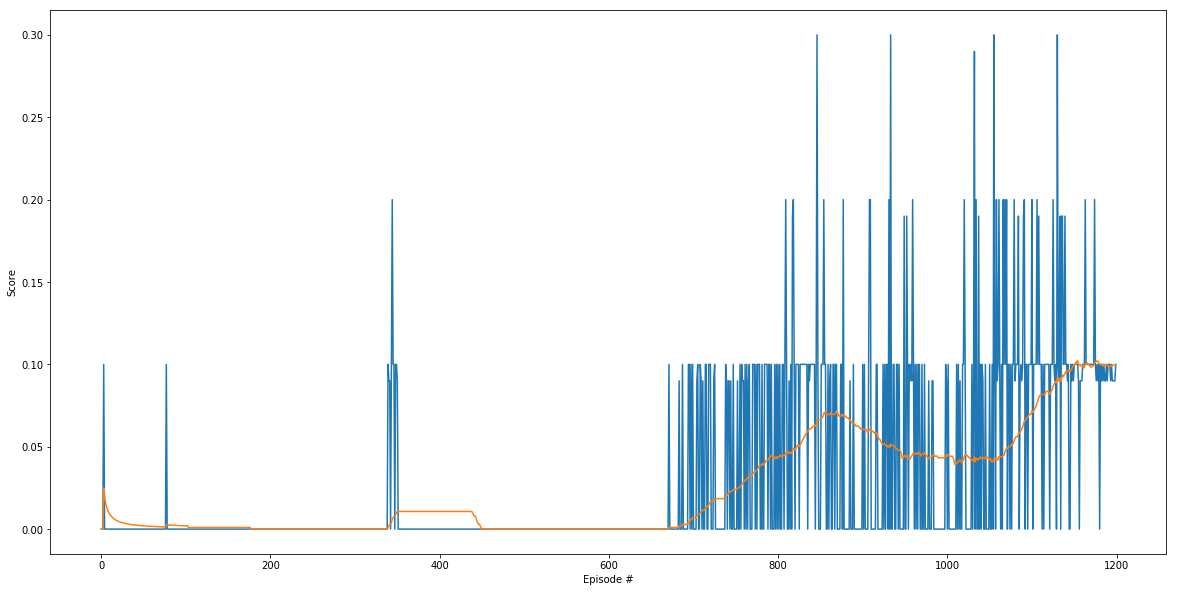

Episode 1210 Average Score deque: 0.10  time: 435.06696105003357
Episode 1220 Average Score deque: 0.10  time: 440.50517177581787
Episode 1230 Average Score deque: 0.10  time: 444.6456639766693
Episode 1240 Average Score deque: 0.10  time: 449.55892539024353
Episode 1250 Average Score deque: 0.10  time: 454.94214034080505
Episode 1260 Average Score deque: 0.10  time: 459.64625358581543
Episode 1270 Average Score deque: 0.10  time: 464.4457497596741
Episode 1280 Average Score deque: 0.10  time: 468.59942960739136
Episode 1290 Average Score deque: 0.10  time: 474.84011816978455
Episode 1300 Average Score deque: 0.10  time: 479.90281915664673
Episode 1310 Average Score deque: 0.10  time: 484.9054765701294
Episode 1320 Average Score deque: 0.10  time: 490.8433425426483
Episode 1330 Average Score deque: 0.10  time: 497.5480737686157
Episode 1340 Average Score deque: 0.10  time: 503.9997477531433
Episode 1350 Average Score deque: 0.10  time: 510.8205986022949
Episode 1360 Average Score deque

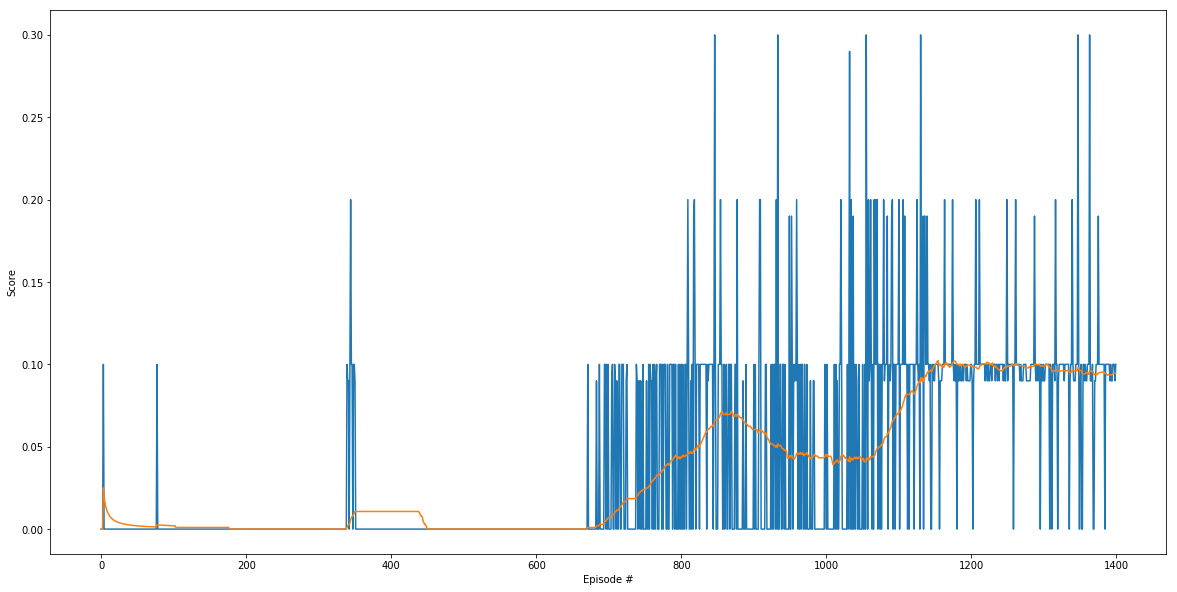

Episode 1410 Average Score deque: 0.10  time: 549.2499284744263
Episode 1420 Average Score deque: 0.10  time: 554.7833111286163
Episode 1430 Average Score deque: 0.10  time: 563.733677148819
Episode 1440 Average Score deque: 0.10  time: 570.3439571857452
Episode 1450 Average Score deque: 0.10  time: 580.2430102825165
Episode 1460 Average Score deque: 0.11  time: 586.9172563552856
Episode 1470 Average Score deque: 0.11  time: 592.8816297054291
Episode 1480 Average Score deque: 0.11  time: 600.7823638916016
Episode 1490 Average Score deque: 0.11  time: 607.3530197143555
Episode 1500 Average Score deque: 0.11  time: 617.8696694374084
Episode 1510 Average Score deque: 0.12  time: 626.2259984016418
Episode 1520 Average Score deque: 0.13  time: 637.5858588218689
Episode 1530 Average Score deque: 0.13  time: 651.4145476818085
Episode 1540 Average Score deque: 0.13  time: 661.3796365261078
Episode 1550 Average Score deque: 0.14  time: 673.2376382350922
Episode 1560 Average Score deque: 0.14  t

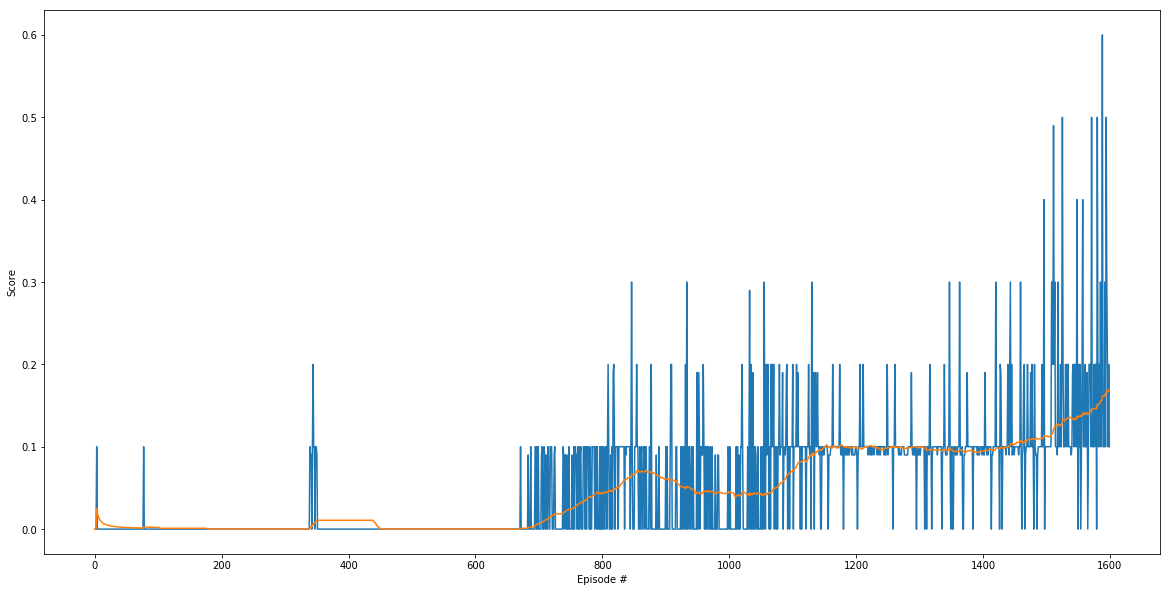

Episode 1610 Average Score deque: 0.17  time: 769.1068794727325
Episode 1620 Average Score deque: 0.16  time: 781.9431710243225
Episode 1630 Average Score deque: 0.17  time: 795.8201568126678
Episode 1640 Average Score deque: 0.19  time: 838.3402812480927
Episode 1650 Average Score deque: 0.21  time: 861.1478457450867
Episode 1660 Average Score deque: 0.25  time: 904.8798036575317
Episode 1670 Average Score deque: 0.28  time: 941.2564227581024
Episode 1680 Average Score deque: 0.34  time: 993.7537002563477
Episode 1690 Average Score deque: 0.37  time: 1042.4869408607483
Episode 1700 Average Score deque: 0.39  time: 1076.0826818943024
Episode 1710 Average Score deque: 0.45  time: 1146.6113669872284
Saved actor and local network for Average Score deque is >= 0.50
Episode 1720 Average Score deque: 0.54  time: 1206.8741252422333
Episode 1730 Average Score deque: 0.59  time: 1243.2522068023682
Saved actor and local network for Average Score deque is >= 0.60
Episode 1740 Average Score deque:

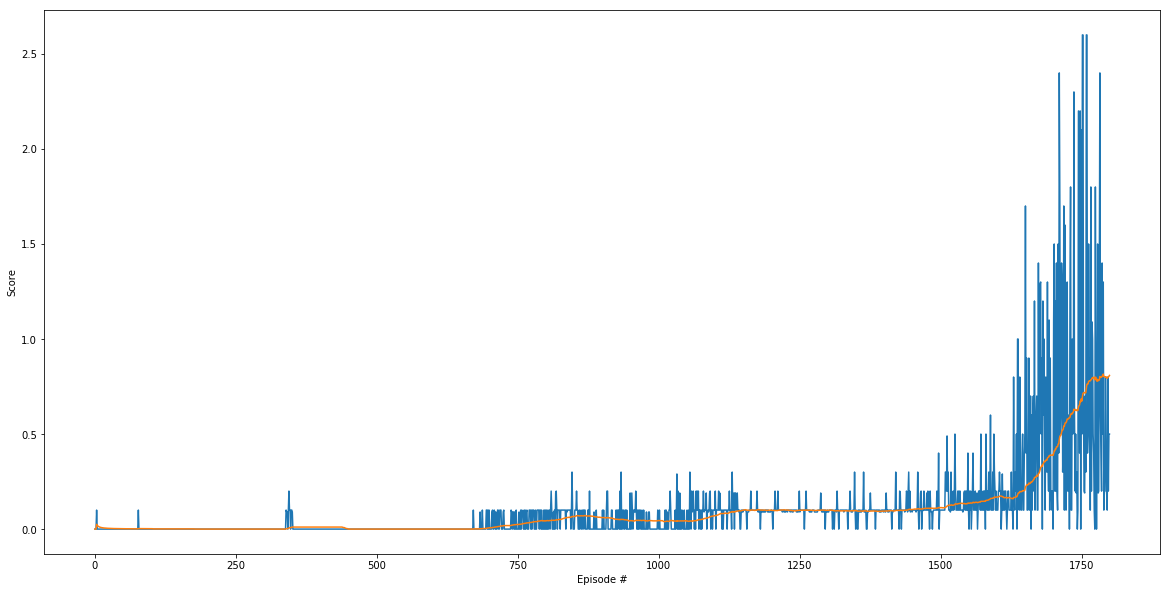

Episode 1810 Average Score deque: 0.78  time: 1645.6445412635803
Episode 1820 Average Score deque: 0.72  time: 1683.5422718524933
Episode 1830 Average Score deque: 0.69  time: 1723.9669125080109
Episode 1840 Average Score deque: 0.68  time: 1776.0639989376068
Episode 1850 Average Score deque: 0.66  time: 1816.852975845337
Episode 1860 Average Score deque: 0.57  time: 1842.0811650753021
Episode 1870 Average Score deque: 0.61  time: 1917.6282930374146
Episode 1880 Average Score deque: 0.60  time: 1952.287369966507
Episode 1890 Average Score deque: 0.59  time: 2013.4514725208282
Episode 1900 Average Score deque: 0.62  time: 2056.7358343601227
Episode 1910 Average Score deque: 0.63  time: 2092.4386785030365
Episode 1920 Average Score deque: 0.63  time: 2127.577236175537
Episode 1930 Average Score deque: 0.67  time: 2191.5124366283417
Episode 1940 Average Score deque: 0.64  time: 2226.2205798625946
Episode 1950 Average Score deque: 0.62  time: 2252.3007118701935
Episode 1960 Average Score d

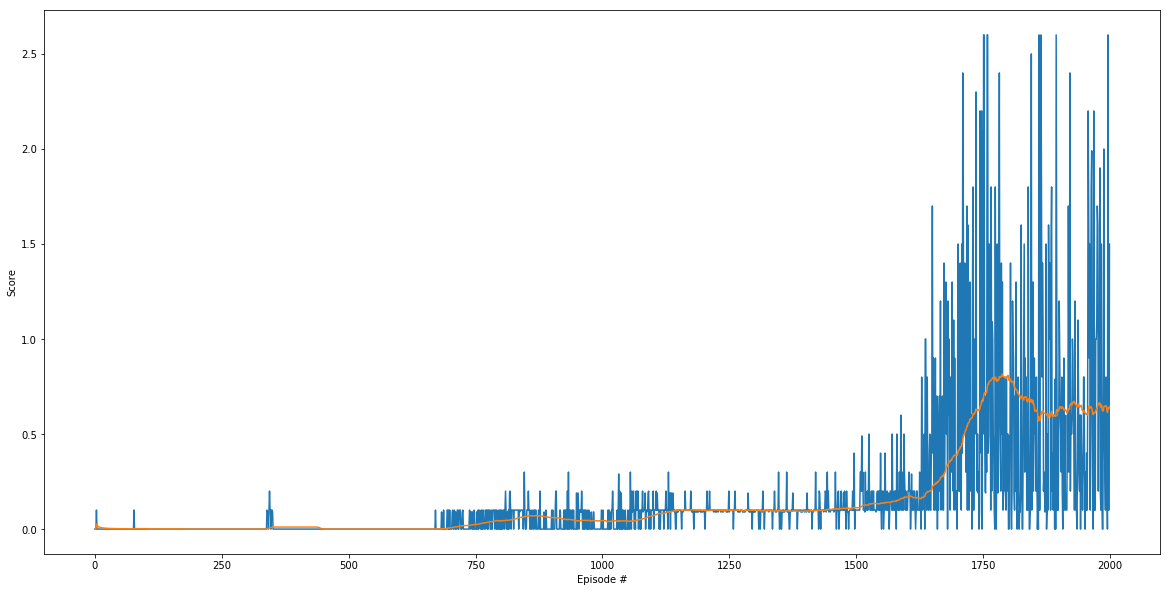

Episode 2010 Average Score deque: 0.65  time: 2573.848007917404
Episode 2020 Average Score deque: 0.67  time: 2614.4875502586365
Episode 2030 Average Score deque: 0.66  time: 2660.347630262375
Episode 2040 Average Score deque: 0.69  time: 2713.3281581401825
Episode 2050 Average Score deque: 0.71  time: 2757.7370936870575
Episode 2060 Average Score deque: 0.70  time: 2791.0618193149567
Episode 2070 Average Score deque: 0.69  time: 2855.7949459552765
Episode 2080 Average Score deque: 0.69  time: 2927.3428568840027
Episode 2090 Average Score deque: 0.69  time: 2979.2984302043915
Episode 2100 Average Score deque: 0.73  time: 3041.598354101181
Episode 2110 Average Score deque: 0.72  time: 3072.239100933075
Episode 2120 Average Score deque: 0.70  time: 3108.2047786712646
Episode 2130 Average Score deque: 0.69  time: 3156.154776573181
Episode 2140 Average Score deque: 0.64  time: 3176.015213251114
Episode 2150 Average Score deque: 0.63  time: 3201.9930472373962
Episode 2160 Average Score dequ

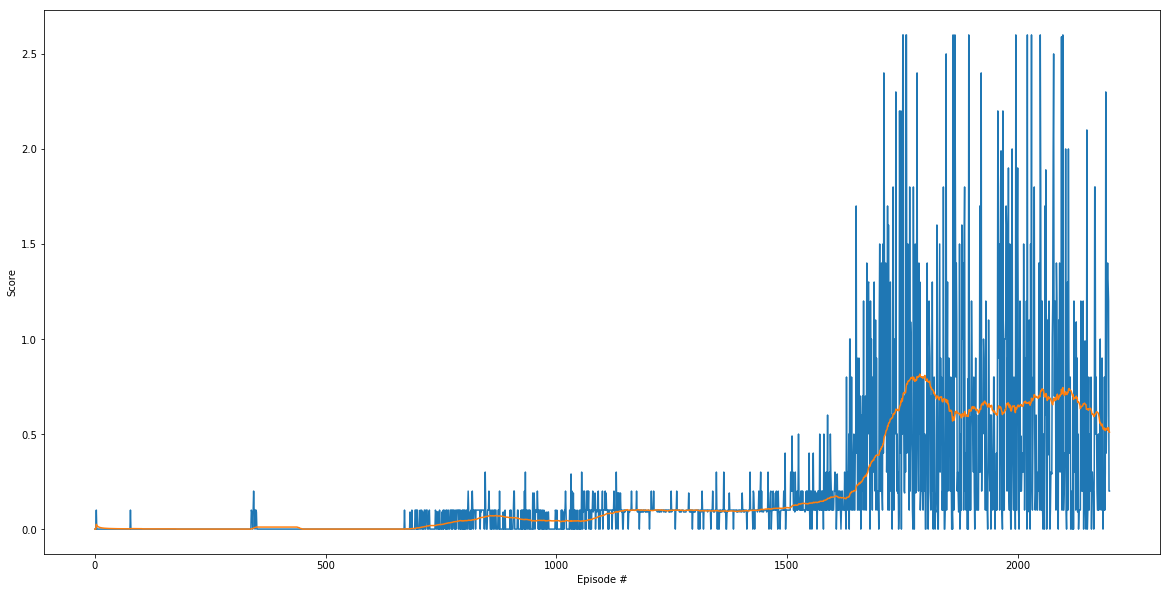

Episode 2210 Average Score deque: 0.49  time: 3403.7076783180237
Episode 2220 Average Score deque: 0.50  time: 3441.6004350185394
Episode 2230 Average Score deque: 0.47  time: 3479.6215221881866
Episode 2240 Average Score deque: 0.52  time: 3535.9870898723602
Episode 2250 Average Score deque: 0.52  time: 3562.88009929657
Episode 2260 Average Score deque: 0.53  time: 3604.4807193279266
Episode 2270 Average Score deque: 0.57  time: 3670.422946214676
Episode 2280 Average Score deque: 0.61  time: 3728.6736748218536
Episode 2290 Average Score deque: 0.61  time: 3746.4636538028717
Episode 2300 Average Score deque: 0.56  time: 3776.6158730983734
Episode 2310 Average Score deque: 0.62  time: 3837.433094024658
Episode 2320 Average Score deque: 0.61  time: 3873.3840005397797
Episode 2330 Average Score deque: 0.65  time: 3920.5269820690155
Episode 2340 Average Score deque: 0.63  time: 3955.0073943138123
Episode 2350 Average Score deque: 0.63  time: 3988.949691057205
Episode 2360 Average Score deq

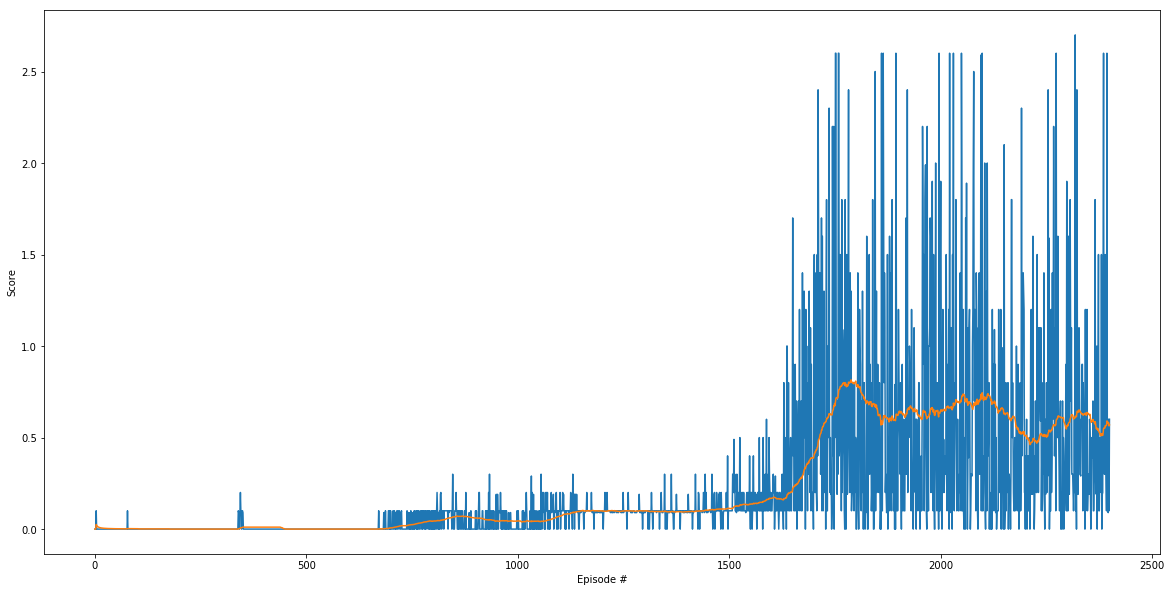

Episode 2410 Average Score deque: 0.56  time: 4225.207156658173
Episode 2420 Average Score deque: 0.56  time: 4262.859436511993
Episode 2430 Average Score deque: 0.53  time: 4288.065171718597
Episode 2440 Average Score deque: 0.54  time: 4319.488147497177
Episode 2450 Average Score deque: 0.52  time: 4342.573908805847
Episode 2460 Average Score deque: 0.54  time: 4378.714944601059
Episode 2470 Average Score deque: 0.57  time: 4437.049250841141
Episode 2480 Average Score deque: 0.63  time: 4492.022998332977
Episode 2490 Average Score deque: 0.62  time: 4541.668268442154
Episode 2500 Average Score deque: 0.60  time: 4568.725978851318
Episode 2510 Average Score deque: 0.57  time: 4601.172767400742
Episode 2520 Average Score deque: 0.58  time: 4635.916587591171
Episode 2530 Average Score deque: 0.63  time: 4693.388023376465
Episode 2540 Average Score deque: 0.63  time: 4735.058458805084
Episode 2550 Average Score deque: 0.67  time: 4783.395240545273
Episode 2560 Average Score deque: 0.67  

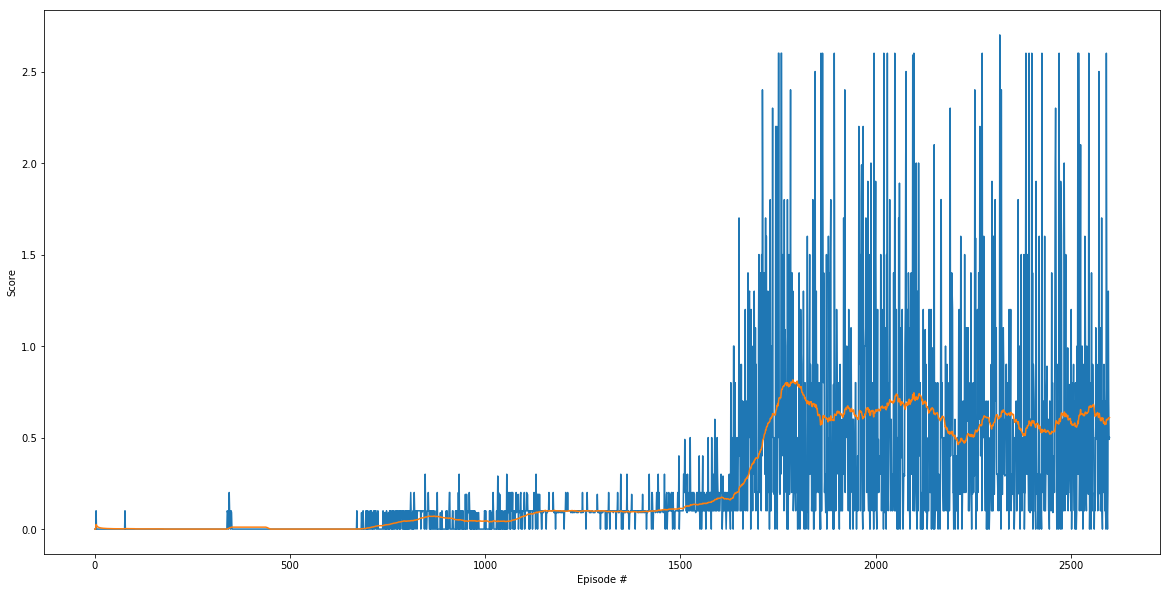

Episode 2610 Average Score deque: 0.61  time: 4992.213539600372
Episode 2620 Average Score deque: 0.57  time: 5007.07994556427
Episode 2630 Average Score deque: 0.51  time: 5030.65749001503
Episode 2640 Average Score deque: 0.49  time: 5050.971367359161
Episode 2650 Average Score deque: 0.51  time: 5119.480522155762
Episode 2660 Average Score deque: 0.52  time: 5162.714823961258
Episode 2670 Average Score deque: 0.52  time: 5188.671762943268
Episode 2680 Average Score deque: 0.52  time: 5243.018858671188
Episode 2690 Average Score deque: 0.53  time: 5275.796901702881
Episode 2700 Average Score deque: 0.48  time: 5293.7867040634155
Episode 2710 Average Score deque: 0.48  time: 5322.578759670258
Episode 2720 Average Score deque: 0.49  time: 5343.8730545043945
Episode 2730 Average Score deque: 0.52  time: 5395.683316230774
Episode 2740 Average Score deque: 0.56  time: 5447.365571737289
Episode 2750 Average Score deque: 0.51  time: 5474.981085777283
Episode 2760 Average Score deque: 0.52  

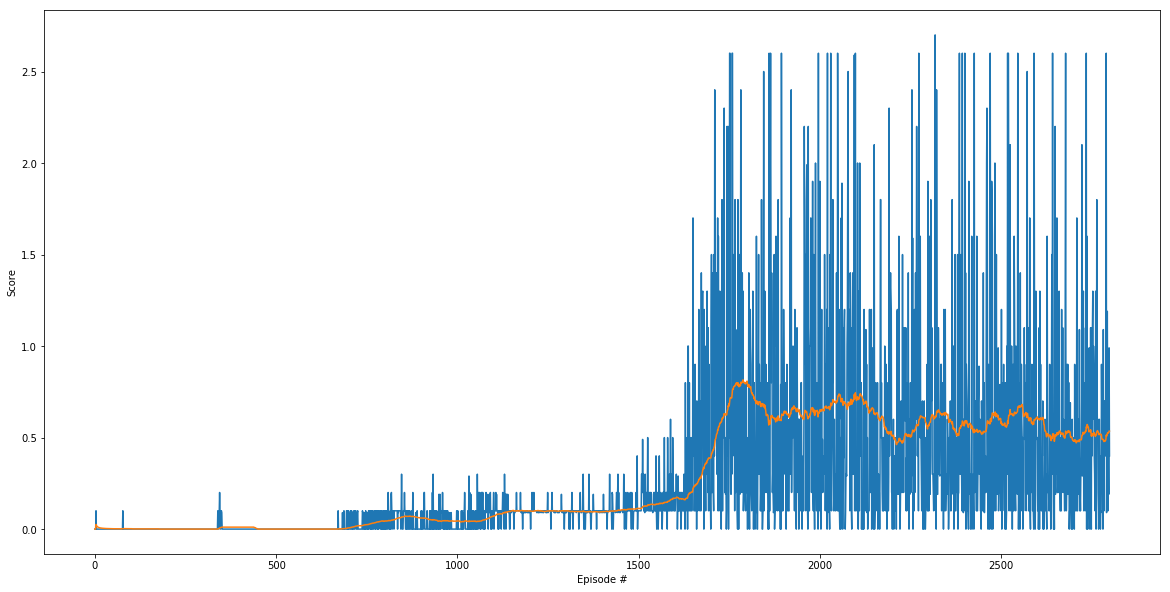

Episode 2810 Average Score deque: 0.53  time: 5698.2092225551605
Episode 2820 Average Score deque: 0.57  time: 5741.621941804886
Episode 2830 Average Score deque: 0.56  time: 5787.920930862427
Episode 2840 Average Score deque: 0.55  time: 5830.680362939835
Episode 2850 Average Score deque: 0.56  time: 5864.149653673172
Episode 2860 Average Score deque: 0.54  time: 5900.151200056076
Episode 2870 Average Score deque: 0.54  time: 5937.864960193634
Episode 2880 Average Score deque: 0.57  time: 5978.004684448242
Episode 2890 Average Score deque: 0.59  time: 6029.191351890564
Episode 2900 Average Score deque: 0.56  time: 6052.527942895889
Episode 2910 Average Score deque: 0.57  time: 6091.329815626144
Episode 2920 Average Score deque: 0.55  time: 6122.803831338882
Episode 2930 Average Score deque: 0.57  time: 6181.570181131363
Episode 2940 Average Score deque: 0.54  time: 6208.320204257965
Episode 2950 Average Score deque: 0.54  time: 6238.099136590958
Episode 2960 Average Score deque: 0.53 

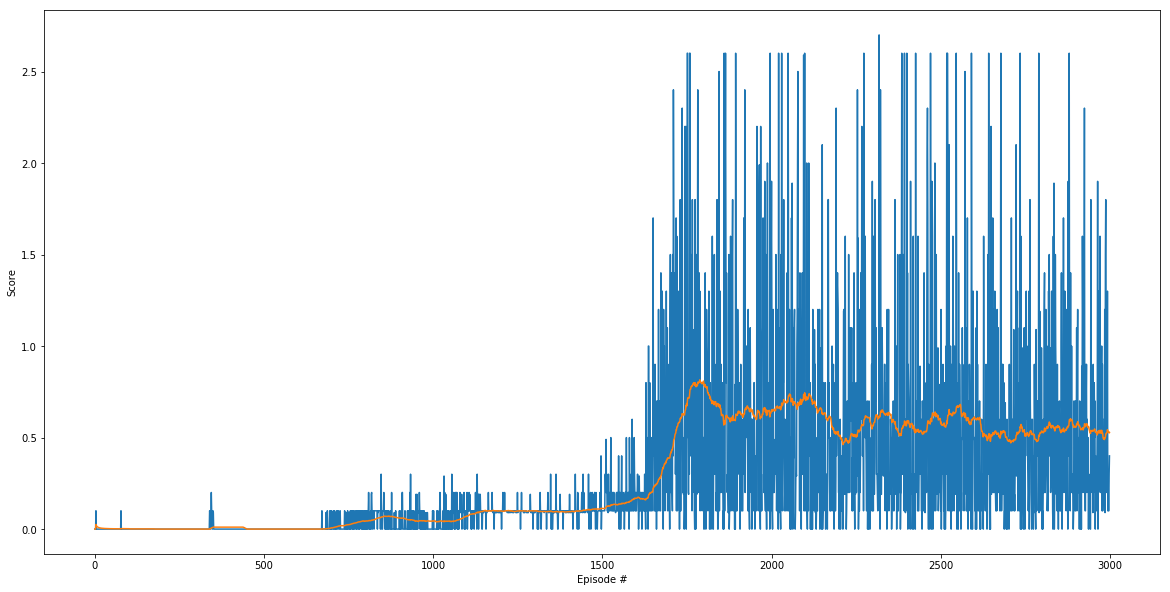

Episode 3010 Average Score deque: 0.53  time: 6505.317767381668
Episode 3020 Average Score deque: 0.52  time: 6535.095387220383
Episode 3030 Average Score deque: 0.48  time: 6563.780679702759
Episode 3040 Average Score deque: 0.46  time: 6579.221306800842
Episode 3050 Average Score deque: 0.43  time: 6592.0996861457825
Episode 3060 Average Score deque: 0.41  time: 6606.277937173843
Episode 3070 Average Score deque: 0.41  time: 6636.327010393143
Episode 3080 Average Score deque: 0.40  time: 6667.441877365112
Episode 3090 Average Score deque: 0.37  time: 6710.96485710144
Episode 3100 Average Score deque: 0.41  time: 6765.4326248168945
Episode 3110 Average Score deque: 0.38  time: 6788.668030500412
Episode 3120 Average Score deque: 0.42  time: 6833.33123755455
Episode 3130 Average Score deque: 0.46  time: 6893.866719245911
Episode 3140 Average Score deque: 0.50  time: 6944.09393787384
Episode 3150 Average Score deque: 0.53  time: 6970.564725399017
Episode 3160 Average Score deque: 0.55  t

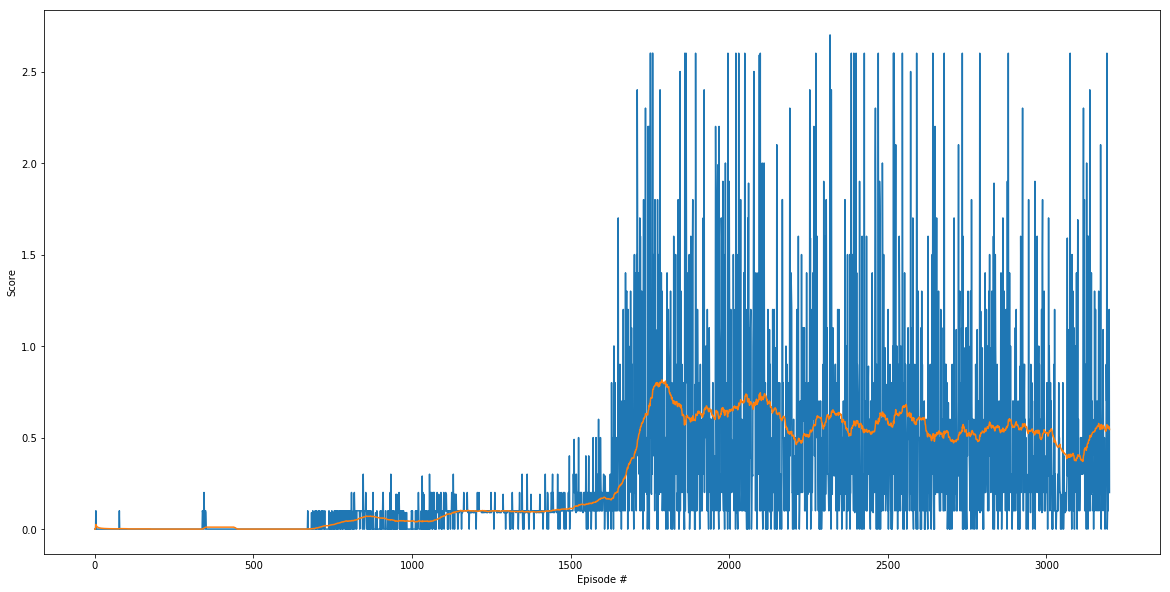

Episode 3210 Average Score deque: 0.55  time: 7181.009889602661
Episode 3220 Average Score deque: 0.53  time: 7218.8551614284515
Episode 3230 Average Score deque: 0.52  time: 7270.603104829788
Episode 3240 Average Score deque: 0.53  time: 7317.861092329025
Episode 3250 Average Score deque: 0.54  time: 7348.54632973671
Episode 3260 Average Score deque: 0.56  time: 7383.762086868286
Episode 3270 Average Score deque: 0.59  time: 7433.544759988785
Episode 3280 Average Score deque: 0.59  time: 7482.296441793442
Episode 3290 Average Score deque: 0.68  time: 7553.624608755112
Episode 3300 Average Score deque: 0.68  time: 7599.446999073029
Episode 3310 Average Score deque: 0.71  time: 7649.939291238785
Episode 3320 Average Score deque: 0.72  time: 7695.3354387283325
Episode 3330 Average Score deque: 0.71  time: 7724.854248285294
Episode 3340 Average Score deque: 0.68  time: 7753.41092300415
Episode 3350 Average Score deque: 0.69  time: 7794.937984466553
Episode 3360 Average Score deque: 0.65  

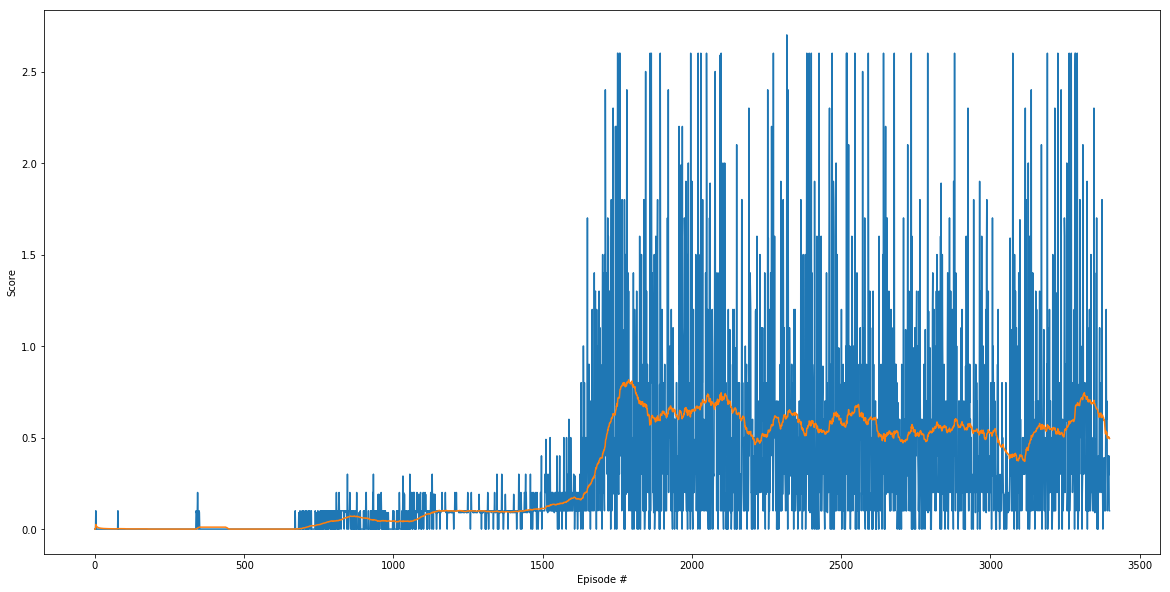

Episode 3410 Average Score deque: 0.45  time: 7936.45289182663
Episode 3420 Average Score deque: 0.44  time: 7982.007886648178
Episode 3430 Average Score deque: 0.44  time: 8021.224427700043
Episode 3440 Average Score deque: 0.47  time: 8066.898261785507
Episode 3450 Average Score deque: 0.46  time: 8092.358142375946
Episode 3460 Average Score deque: 0.46  time: 8115.0244200229645
Episode 3470 Average Score deque: 0.44  time: 8132.690914154053
Episode 3480 Average Score deque: 0.43  time: 8162.7269077301025
Episode 3490 Average Score deque: 0.45  time: 8202.602108001709
Episode 3500 Average Score deque: 0.47  time: 8236.809058189392
Episode 3510 Average Score deque: 0.47  time: 8249.734582424164
Episode 3520 Average Score deque: 0.46  time: 8277.232742071152
Episode 3530 Average Score deque: 0.43  time: 8300.719036102295
Episode 3540 Average Score deque: 0.40  time: 8332.769653558731
Episode 3550 Average Score deque: 0.41  time: 8374.117941141129
Episode 3560 Average Score deque: 0.46 

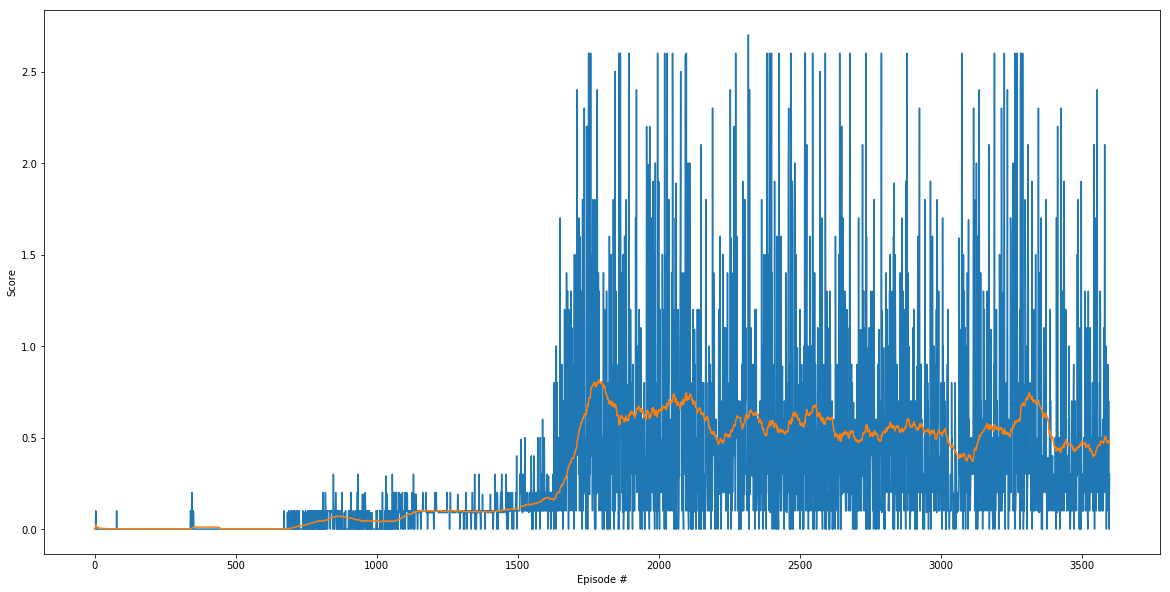

Episode 3610 Average Score deque: 0.46  time: 8557.108003377914
Episode 3620 Average Score deque: 0.44  time: 8575.11472439766
Episode 3630 Average Score deque: 0.44  time: 8595.501636505127
Episode 3640 Average Score deque: 0.44  time: 8618.129605054855
Episode 3650 Average Score deque: 0.42  time: 8643.386924505234
Episode 3660 Average Score deque: 0.39  time: 8674.388607501984
Episode 3670 Average Score deque: 0.39  time: 8708.482624530792
Episode 3680 Average Score deque: 0.40  time: 8742.01296544075
Episode 3690 Average Score deque: 0.36  time: 8756.73576927185
Episode 3700 Average Score deque: 0.37  time: 8783.938184976578
Episode 3710 Average Score deque: 0.39  time: 8804.783022642136
Episode 3720 Average Score deque: 0.40  time: 8823.987001895905
Episode 3730 Average Score deque: 0.40  time: 8848.74256825447
Episode 3740 Average Score deque: 0.40  time: 8878.49583530426
Episode 3750 Average Score deque: 0.39  time: 8908.229888916016
Episode 3760 Average Score deque: 0.38  time:

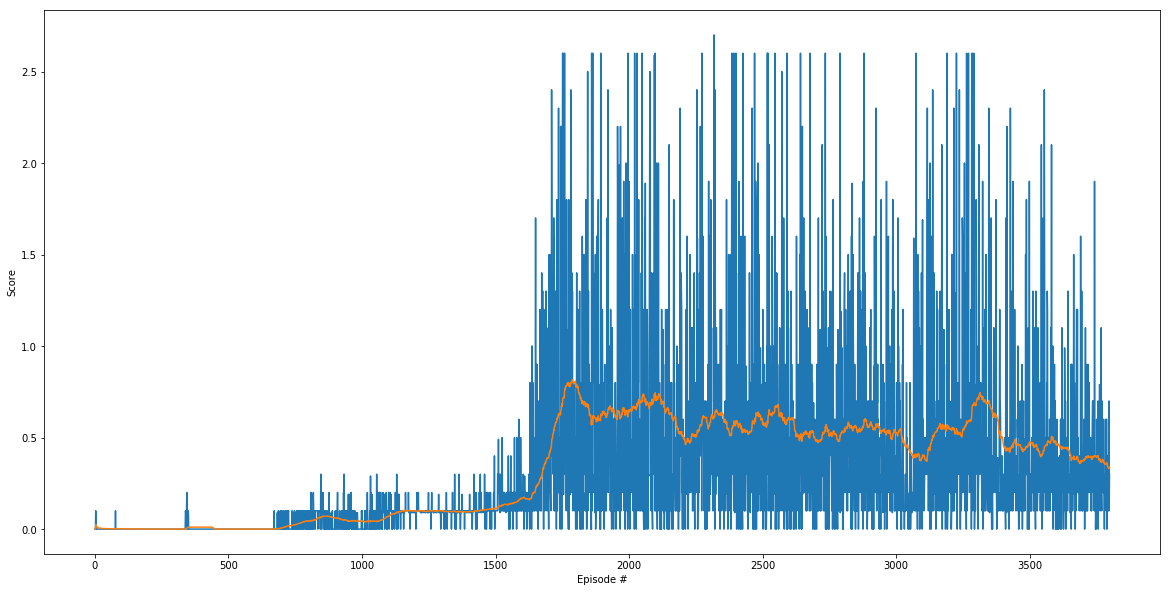

Episode 3810 Average Score deque: 0.32  time: 9017.882170677185
Episode 3820 Average Score deque: 0.31  time: 9036.200288057327
Episode 3830 Average Score deque: 0.30  time: 9054.61281466484
Episode 3840 Average Score deque: 0.29  time: 9071.474143505096
Episode 3850 Average Score deque: 0.28  time: 9095.172551870346
Episode 3860 Average Score deque: 0.28  time: 9112.523176193237
Episode 3870 Average Score deque: 0.29  time: 9138.051496505737
Episode 3880 Average Score deque: 0.29  time: 9157.773072242737
Episode 3890 Average Score deque: 0.31  time: 9186.924087762833
Episode 3900 Average Score deque: 0.32  time: 9209.735944986343
Episode 3910 Average Score deque: 0.32  time: 9226.178052663803
Episode 3920 Average Score deque: 0.33  time: 9254.677931070328
Episode 3930 Average Score deque: 0.33  time: 9269.085355520248
Episode 3940 Average Score deque: 0.36  time: 9304.396076440811
Episode 3950 Average Score deque: 0.37  time: 9326.466831684113
Episode 3960 Average Score deque: 0.37  t

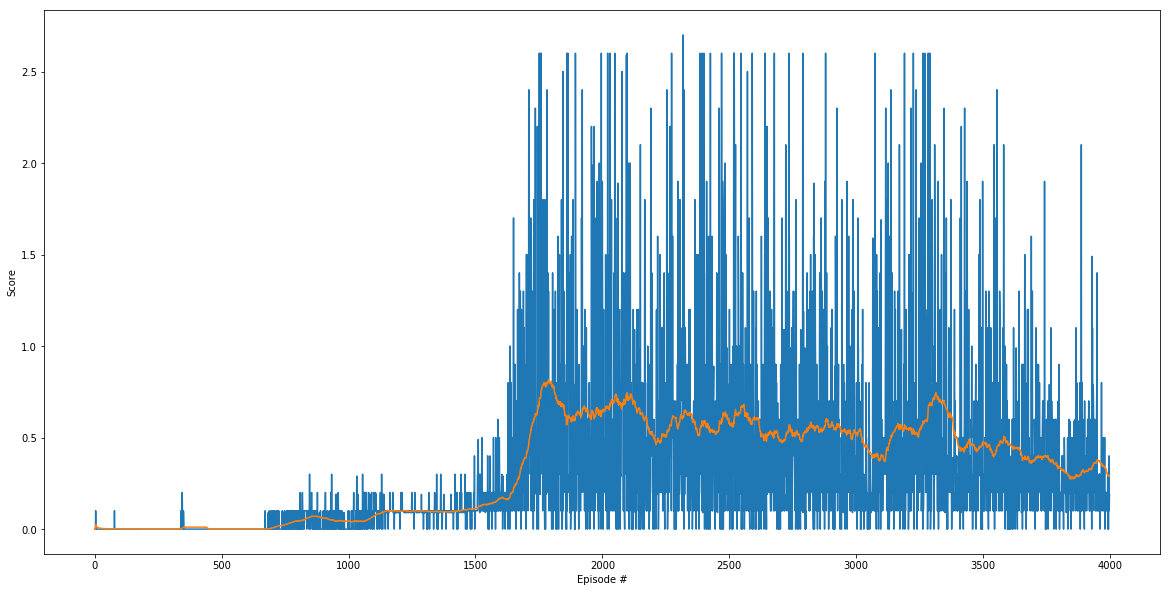

Episode 4010 Average Score deque: 0.29  time: 9421.849263191223
Episode 4020 Average Score deque: 0.28  time: 9444.826326608658
Episode 4030 Average Score deque: 0.30  time: 9466.712179660797
Episode 4040 Average Score deque: 0.27  time: 9482.071231842041
Episode 4050 Average Score deque: 0.25  time: 9498.152354240417
Episode 4060 Average Score deque: 0.26  time: 9517.53877902031
Episode 4070 Average Score deque: 0.26  time: 9535.594450950623
Episode 4080 Average Score deque: 0.27  time: 9557.095856666565
Episode 4090 Average Score deque: 0.29  time: 9580.693336725235
Episode 4100 Average Score deque: 0.30  time: 9602.808125257492
Episode 4110 Average Score deque: 0.31  time: 9624.896800279617
Episode 4120 Average Score deque: 0.33  time: 9656.581794500351
Episode 4130 Average Score deque: 0.35  time: 9687.846003770828
Episode 4140 Average Score deque: 0.37  time: 9717.701993703842
Episode 4150 Average Score deque: 0.38  time: 9738.504536628723
Episode 4160 Average Score deque: 0.40  t

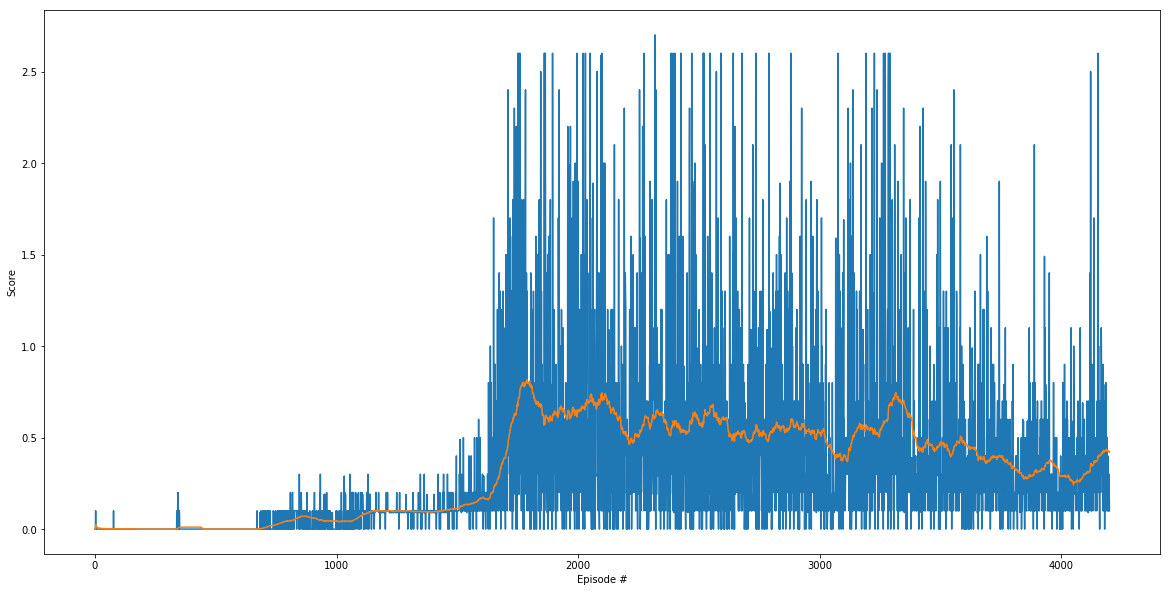

Episode 4210 Average Score deque: 0.41  time: 9890.022230625153
Episode 4220 Average Score deque: 0.40  time: 9913.067867994308
Episode 4230 Average Score deque: 0.37  time: 9939.900893449783
Episode 4240 Average Score deque: 0.35  time: 9957.519788742065
Episode 4250 Average Score deque: 0.35  time: 9979.02945303917
Episode 4260 Average Score deque: 0.32  time: 9998.875070810318
Episode 4270 Average Score deque: 0.29  time: 10015.11986207962
Episode 4280 Average Score deque: 0.29  time: 10033.115088224411
Episode 4290 Average Score deque: 0.28  time: 10051.477732658386
Episode 4300 Average Score deque: 0.29  time: 10067.343725919724
Episode 4310 Average Score deque: 0.30  time: 10088.09560418129
Episode 4320 Average Score deque: 0.29  time: 10102.73586845398
Episode 4330 Average Score deque: 0.30  time: 10136.530097484589
Episode 4340 Average Score deque: 0.30  time: 10158.358848333359
Episode 4350 Average Score deque: 0.32  time: 10191.045751571655
Episode 4360 Average Score deque: 0

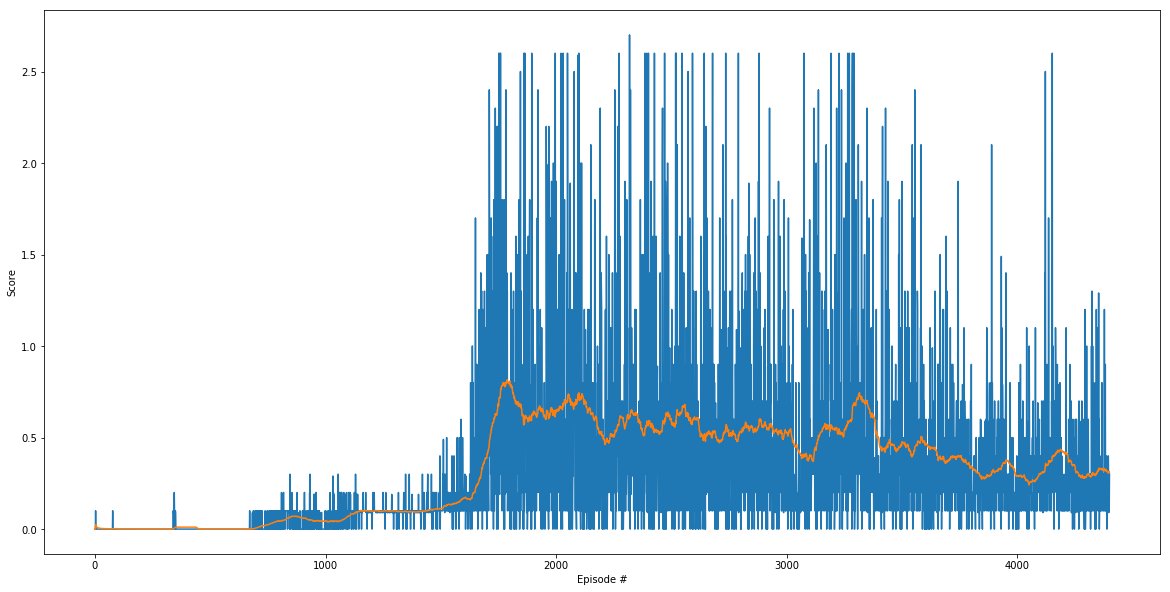

Episode 4410 Average Score deque: 0.32  time: 10304.348713874817
Episode 4420 Average Score deque: 0.33  time: 10325.423527240753
Episode 4430 Average Score deque: 0.30  time: 10341.050588130951
Episode 4440 Average Score deque: 0.31  time: 10366.981080532074
Episode 4450 Average Score deque: 0.28  time: 10376.95054268837
Episode 4460 Average Score deque: 0.27  time: 10392.85467672348
Episode 4470 Average Score deque: 0.29  time: 10413.73947095871
Episode 4480 Average Score deque: 0.28  time: 10430.827459812164
Episode 4490 Average Score deque: 0.29  time: 10452.05873632431
Episode 4500 Average Score deque: 0.29  time: 10470.852642536163
Episode 4510 Average Score deque: 0.29  time: 10503.630923509598
Episode 4520 Average Score deque: 0.29  time: 10528.91807794571
Episode 4530 Average Score deque: 0.29  time: 10548.2966735363
Episode 4540 Average Score deque: 0.30  time: 10576.131832838058
Episode 4550 Average Score deque: 0.32  time: 10592.403459787369
Episode 4560 Average Score deque

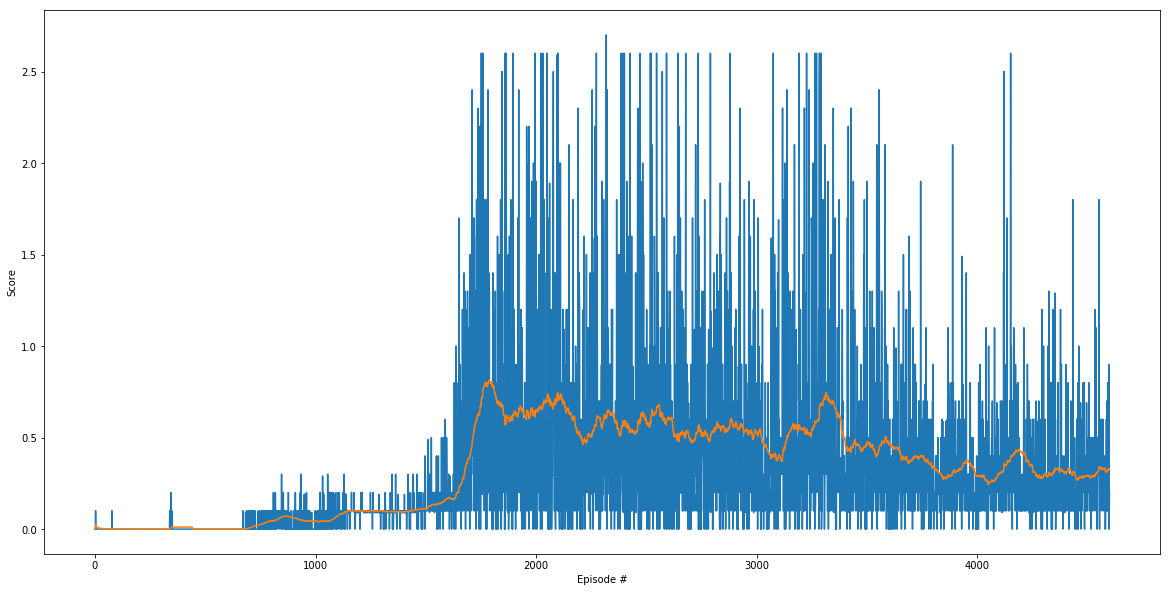

Episode 4610 Average Score deque: 0.34  time: 10742.26517701149
Episode 4620 Average Score deque: 0.34  time: 10763.860372066498
Episode 4630 Average Score deque: 0.34  time: 10779.006528139114
Episode 4640 Average Score deque: 0.31  time: 10788.637197732925
Episode 4650 Average Score deque: 0.30  time: 10804.705318927765
Episode 4660 Average Score deque: 0.29  time: 10829.63674044609
Episode 4670 Average Score deque: 0.29  time: 10852.32045340538
Episode 4680 Average Score deque: 0.30  time: 10873.328937530518
Episode 4690 Average Score deque: 0.30  time: 10902.504774570465
Episode 4700 Average Score deque: 0.28  time: 10922.517594337463
Episode 4710 Average Score deque: 0.26  time: 10937.616797924042
Episode 4720 Average Score deque: 0.26  time: 10960.702373981476
Episode 4730 Average Score deque: 0.27  time: 10983.223953008652
Episode 4740 Average Score deque: 0.28  time: 11003.307889223099
Episode 4750 Average Score deque: 0.29  time: 11024.850441217422
Episode 4760 Average Score d

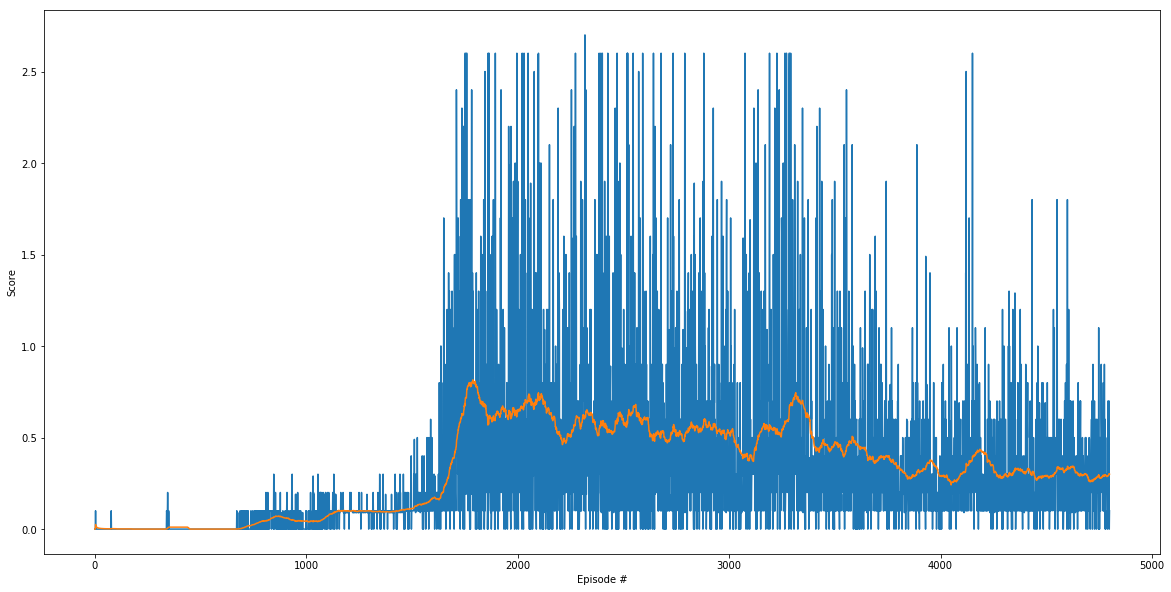

Episode 4810 Average Score deque: 0.30  time: 11163.921100854874
Episode 4820 Average Score deque: 0.29  time: 11177.27736902237
Episode 4830 Average Score deque: 0.27  time: 11190.752837657928
Episode 4840 Average Score deque: 0.28  time: 11209.817578077316
Episode 4850 Average Score deque: 0.29  time: 11240.283380270004
Episode 4860 Average Score deque: 0.29  time: 11264.955096006393
Episode 4870 Average Score deque: 0.27  time: 11279.40692949295
Episode 4880 Average Score deque: 0.26  time: 11296.456708669662
Episode 4890 Average Score deque: 0.27  time: 11322.297203540802
Episode 4900 Average Score deque: 0.27  time: 11342.755593538284
Episode 4910 Average Score deque: 0.29  time: 11368.266132831573
Episode 4920 Average Score deque: 0.32  time: 11397.817718982697
Episode 4930 Average Score deque: 0.33  time: 11422.474250555038
Episode 4940 Average Score deque: 0.32  time: 11441.496105194092
Episode 4950 Average Score deque: 0.32  time: 11479.424751758575
Episode 4960 Average Score 

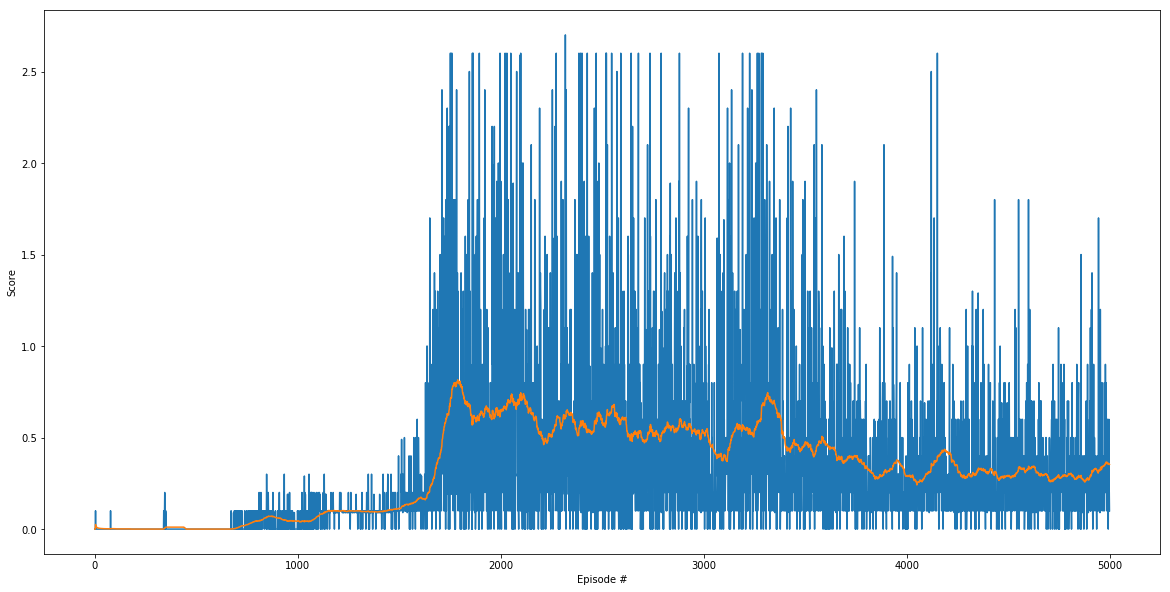

In [6]:
#Create the agent 
agents = [Agent(state_size=state_size, action_size=action_size, random_seed=8) for _ in range(num_agents)]

#launch the training process
scores,scores_deque_avg = ddpg_continuous(num_agents)  

### rough learning curve
Plot the average of the score  episode by episode.

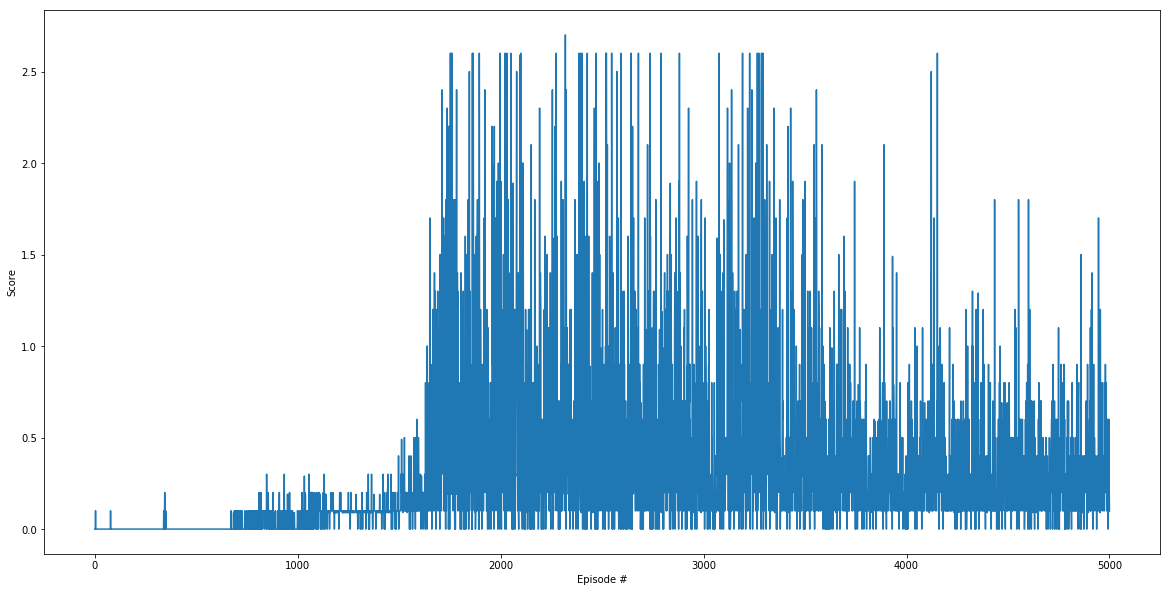

In [7]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,label = 'DDPG Continuous Control')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Smoothed learning curve
plot the average of the score.
window gives us the ability to smooth the curve. For exemple, for the 120th episode, we will average episode 20 to 120 if window = 100.

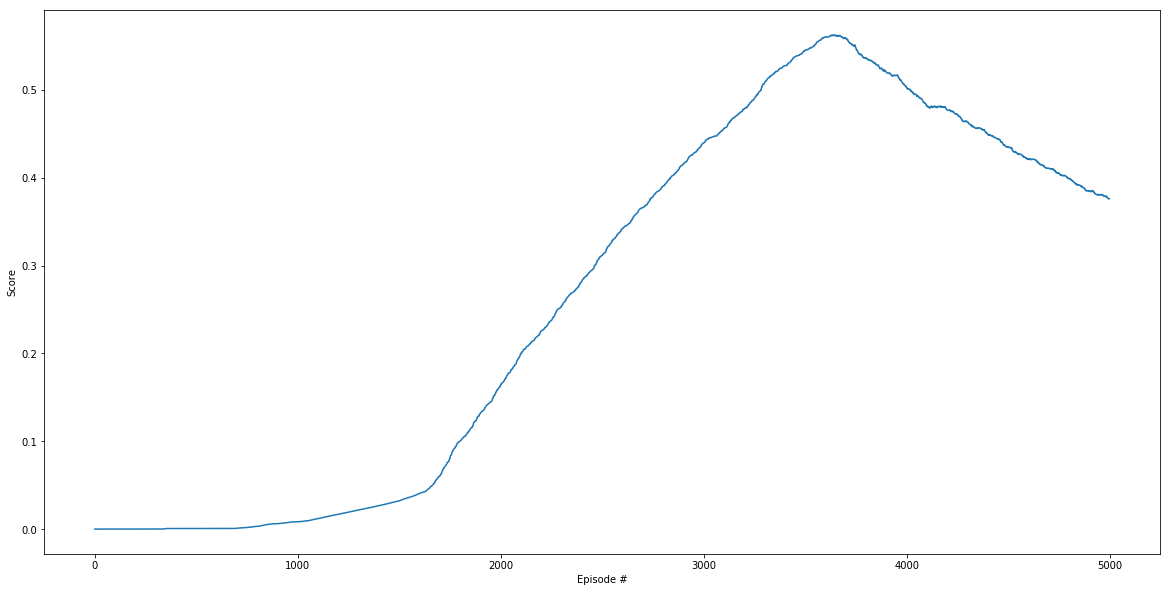

In [10]:
window = 2000
filter = np.ones(window)/window
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(np.convolve(scores, filter)[:-window],label = 'DDPG Continuous Control')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
### Save the agent

In [ ]:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth') # save weight for actor
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth') # save weight for critic

### Load and watch a trained agent

In [14]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents)   

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, random_seed=10)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

meanRewardEveryStep = []
for t_step in range (2000):
    
    
    actions = agent.act(states)         # select an action (for each agent)
    #actions = np.clip(actions, -1, 1)                  # already done with the noise in ddpg_agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    
    #agent.step(states, actions, rewards, next_states, dones)
    states = next_states
    scores = scores + rewards                             # roll over states to next time step
    #meanRewardEveryStep.append(np.mean(rewards))
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Score : {:.2f}'.format(np.max(scores)))

# plot the mean reward among each robotic arm for each step
#fig = plt.figure(figsize=(20,5))
#ax = fig.add_subplot(111)
#plt.plot(np.arange(len(meanRewardEveryStep)), meanRewardEveryStep, label='Reward by step')
#plt.legend()
#plt.ylabel('Reward')
#plt.xlabel('Step #')
#plt.show()

Score : 0.70
